# Ngram Models

In [1]:
from typing import List, Tuple, Dict, Any
import numpy as np
import pandas as pd
from ngram_models import NGramModel, NGramModelSettings, clean_pad
from tqdm import tqdm
import json
from translation_utils import generate_parameters, compute_metrics, print_example, plot_results
from collections import defaultdict

# import sys
# sys.path.append("../")
from Data import load_translation_dataset, BlankspaceTokenizer, TokenizerType
import re

In [2]:
title_re = re.compile(r"[^a-zA-Z ]*((mr)|(ms)|(mrs)|(miss))[^a-zA-Z ]*")
remove_chars = re.compile(r"[126\[\],<>]")
space_norm = re.compile(r" +")
add_unk = re.compile(r"\?")
dash = re.compile(r"(?<=[a-zA-Z0-9])-(?=[a-zA-Z0-9])")

def clean_english(x: str) -> str:
    x = x.lower()
    x = title_re.sub(" ", x)
    x = dash.sub(" ", x)
    x = remove_chars.sub(" ", x)
    x = add_unk.sub(" ", x)
    x = space_norm.sub(" ", x)
    return x.strip()

def clean_etruscan(x: str) -> str:
    x = x.lower()
    x = remove_chars.sub(" ", x)
    x = space_norm.sub(" ", x)
    return x.strip()

etruscan, english = load_translation_dataset("../Data/Etruscan.csv", english_fn=clean_english, etruscan_fn=clean_etruscan)
etp_etruscan, etp_english = load_translation_dataset("../Data/Etruscan.csv", subset="etp", english_fn=clean_english, etruscan_fn=clean_etruscan)
ciep_etruscan, ciep_english = load_translation_dataset("../Data/Etruscan.csv", subset="etp", english_fn=clean_english, etruscan_fn=clean_etruscan)

In [3]:
def print_stats(results):
    df = pd.DataFrame(results)
    print("Mean:")
    print(df.mean())
    print("Standar deviation:")
    print(df.std())
    
def random_split(etruscan: List[str], english: List[str], ratio:float, rng: np.random.RandomState) -> Tuple[List[str], List[str], List[str], List[str]]:
    """Split the dataset in train and test"""
    indexes = np.arange(len(english))
    rng.shuffle(indexes)
    split = int(np.round(ratio * len(indexes)))
    
    train_eng = []
    train_et = []
    for i in indexes[:split]:
        train_eng.append(english[i])
        train_et.append(etruscan[i])

    test_eng = []
    test_et = []
    for i in indexes[split:]:
        test_eng.append(english[i])
        test_et.append(etruscan[i])

    return train_et, train_eng, test_et, test_eng

def run_experiment(
        settings: NGramModelSettings,
        train_et: List[str], 
        train_eng: List[str], 
        test_et: List[str], 
        test_eng: List[str], 
        et_tokenizer: TokenizerType, 
        eng_tokenizer: TokenizerType, 
        examples:int = 1
    ) -> Tuple[Dict[str, float], Tuple[List[str], List[str], List[str]]]:

    model = NGramModel(settings)
    model.train(train_et, train_eng, et_tokenizer, eng_tokenizer)

    pred = [model.predict(i, et_tokenizer)[0] for i in test_et]
    pred = [clean_pad(i, settings) for i in pred]

    scores = compute_metrics(pred, test_eng)
    ex = (test_et[:examples], test_eng[:examples], pred[:examples])
    return scores, ex

def run_n_experiments(
        settings: NGramModelSettings, 
        et: List[str],
        eng: List[str], 
        et_tokenizer: TokenizerType, 
        eng_tokenizer: TokenizerType, 
        n: int = 10, 
        seed: int = 0
    ) -> Tuple[Dict[str, List[float]], Tuple[List[str], List[str], List[str]]]:

    results = defaultdict(list)
    rng = np.random.RandomState(seed)

    for _ in tqdm(range(n), total=n):
        train_et, train_eng, test_et, test_eng = random_split(et, eng, 0.8, rng)
        
        tmp_res, example = run_experiment(settings, train_et, train_eng, test_et, test_eng, et_tokenizer, eng_tokenizer)
        for i, j in tmp_res.items():
            results[i].append(j)
    
    return results, example

def do_job(param_space: Dict[str, Any], et: List[str], eng: List[str], title_prefix: str, output_dir: str = "Results") -> None:
    tokenizer = BlankspaceTokenizer()
    for parameters in generate_parameters(param_space):
        # Run
        settings = NGramModelSettings(**parameters)
        results, example = run_n_experiments(settings, et, eng, tokenizer, tokenizer)

        # Save
        output = output_dir + "/ngram_" + repr(settings) + title_prefix + ".json"
        with open(output, "w") as f:
            json.dump(results, f)

        print_stats(results)
        
        # Print 
        print_example(example)

        # Plot
        plot_results(results, title_prefix + " - " + repr(settings))

## Experiment: Only Etruscan context

Parameters:
* n: 1, 2, 3
* gamma: 0.1
* ignore_order: True, False
* english_etruscan_context: False

Run with ETP, CIEP and both

In [4]:
parameters = {
    "n": [1,2,3],
    "gamma": [1],
    "ignore_order": [True, False],
    "english_etruscan_context": [False]
}

100%|██████████| 10/10 [00:00<00:00, 18.49it/s]


Mean:
bleu     0.405518
chrf     7.727345
ter     92.605930
dtype: float64
Standar deviation:
bleu    0.163195
chrf    0.867003
ter     0.959622
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: an of velethnai of tablet of
------------------------------------------------------------


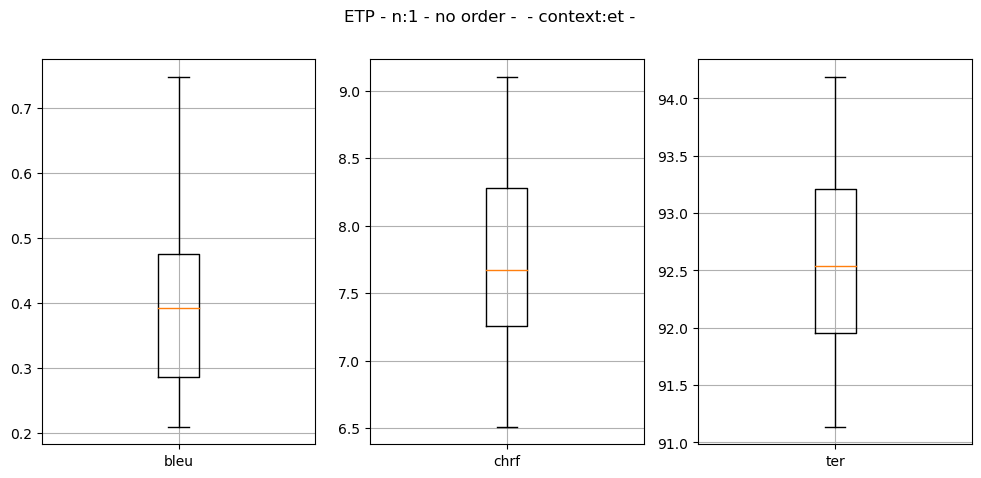

100%|██████████| 10/10 [00:00<00:00, 16.86it/s]


Mean:
bleu     0.005574
chrf     3.248679
ter     98.035438
dtype: float64
Standar deviation:
bleu    0.005781
chrf    0.985582
ter     1.054512
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: cavatha      
------------------------------------------------------------


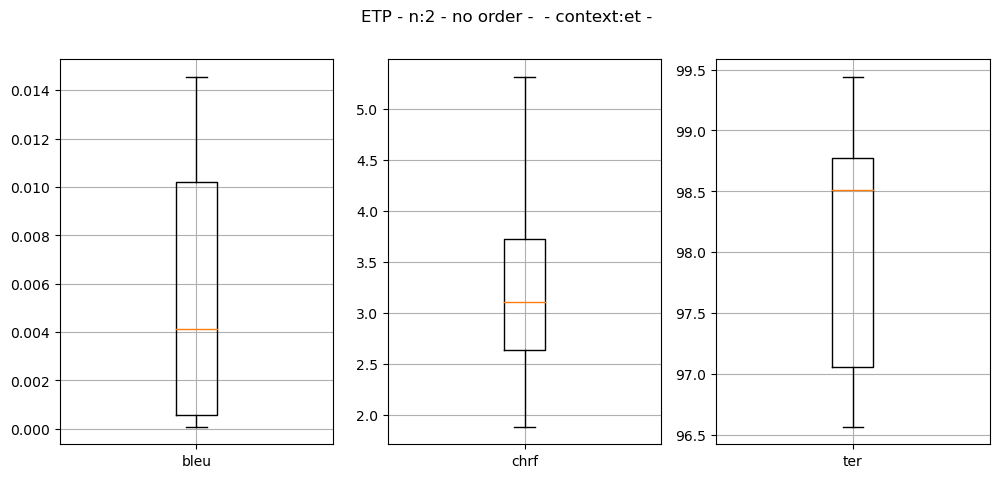

100%|██████████| 10/10 [00:00<00:00, 16.13it/s]


Mean:
bleu     0.000808
chrf     2.523465
ter     98.553415
dtype: float64
Standar deviation:
bleu    0.001263
chrf    0.752606
ter     0.821001
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: of       
------------------------------------------------------------


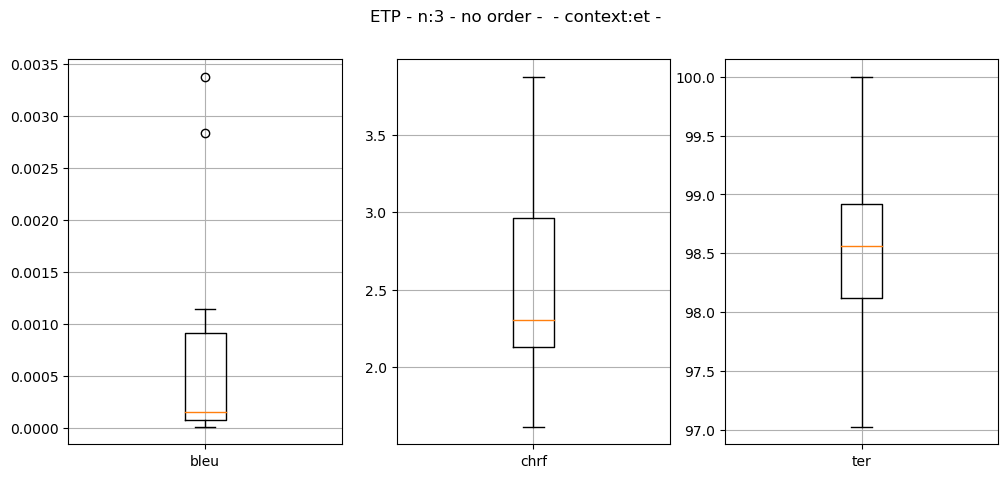

100%|██████████| 10/10 [00:00<00:00, 21.01it/s]


Mean:
bleu     0.405518
chrf     7.727345
ter     92.605930
dtype: float64
Standar deviation:
bleu    0.163195
chrf    0.867003
ter     0.959622
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: an of velethnai of tablet of
------------------------------------------------------------


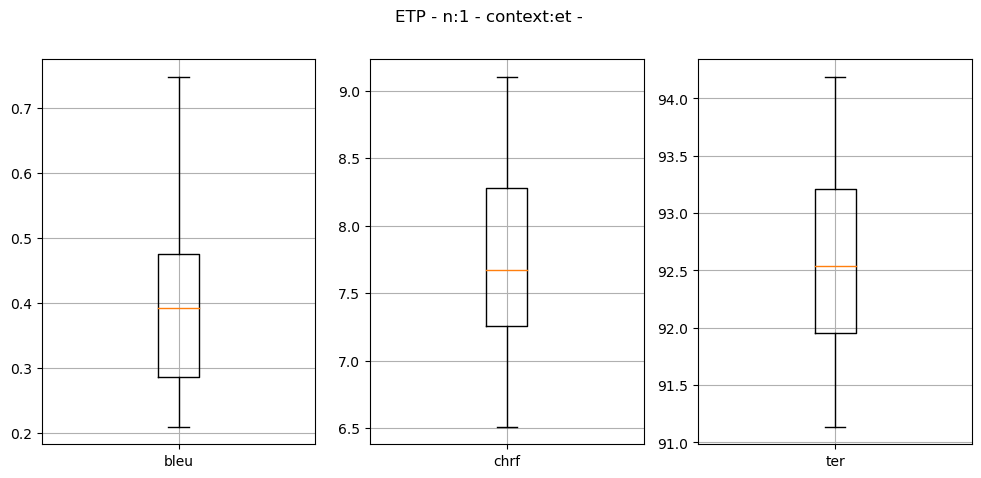

100%|██████████| 10/10 [00:00<00:00, 27.34it/s]


Mean:
bleu     0.005116
chrf     3.211742
ter     98.013066
dtype: float64
Standar deviation:
bleu    0.005464
chrf    1.003788
ter     1.089110
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: cavatha      
------------------------------------------------------------


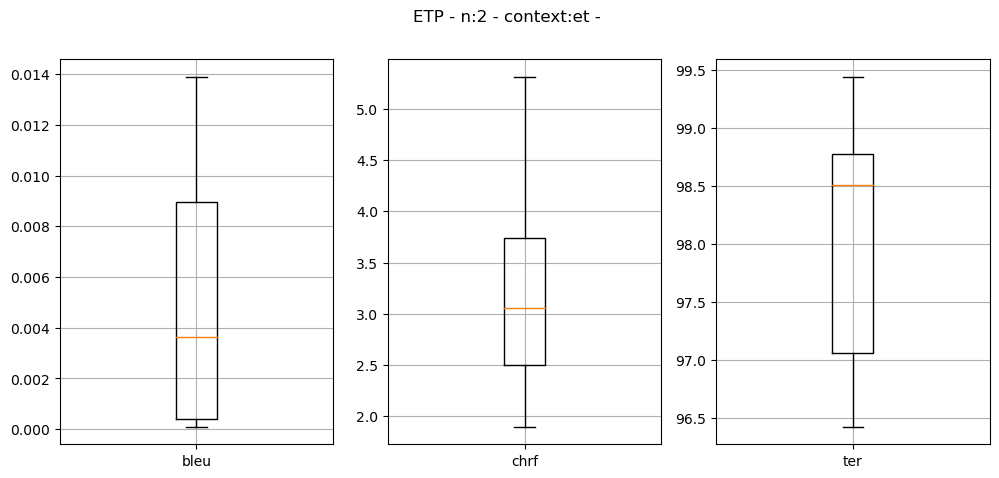

100%|██████████| 10/10 [00:00<00:00, 19.60it/s]


Mean:
bleu     0.000813
chrf     2.522732
ter     98.530532
dtype: float64
Standar deviation:
bleu    0.001275
chrf    0.748407
ter     0.870053
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: of       
------------------------------------------------------------


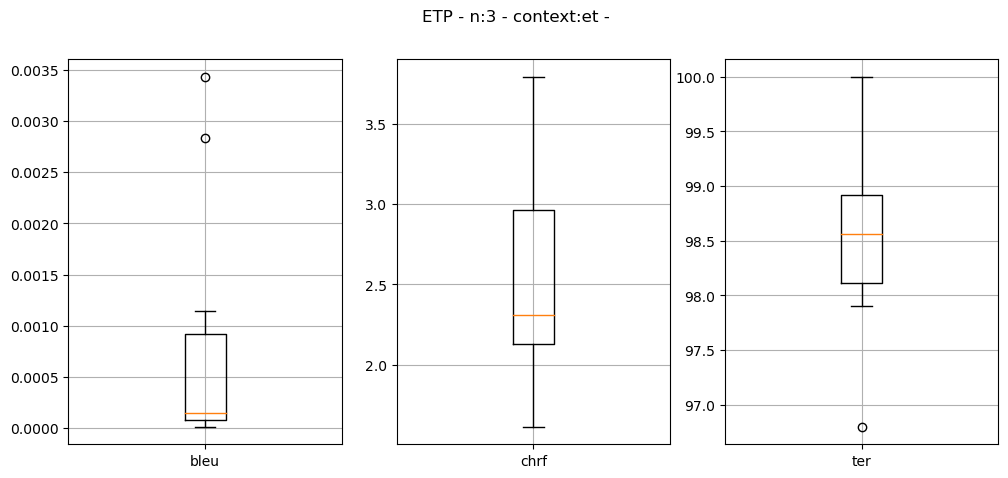

In [5]:
do_job(parameters, etp_etruscan, etp_english, "ETP")
# do_job(parameters, etp_etruscan, etp_english, "CIEP")

## Experiment: Etruscan and English context

Parameters:
* n: 1, 2, 3
* gamma: 0.1
* ignore_order: True, False
* english_etruscan_context: True

Run with ETP, CIEP and both

In [6]:
parameters = {
    "n": [1,2,3],
    "gamma": [1],
    "ignore_order": [True, False],
    "english_etruscan_context": [True]
}

100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Mean:
bleu     0.218767
chrf     3.059171
ter     92.902237
dtype: float64
Standar deviation:
bleu    0.017811
chrf    0.301228
ter     1.159569
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: of of of of of of
------------------------------------------------------------


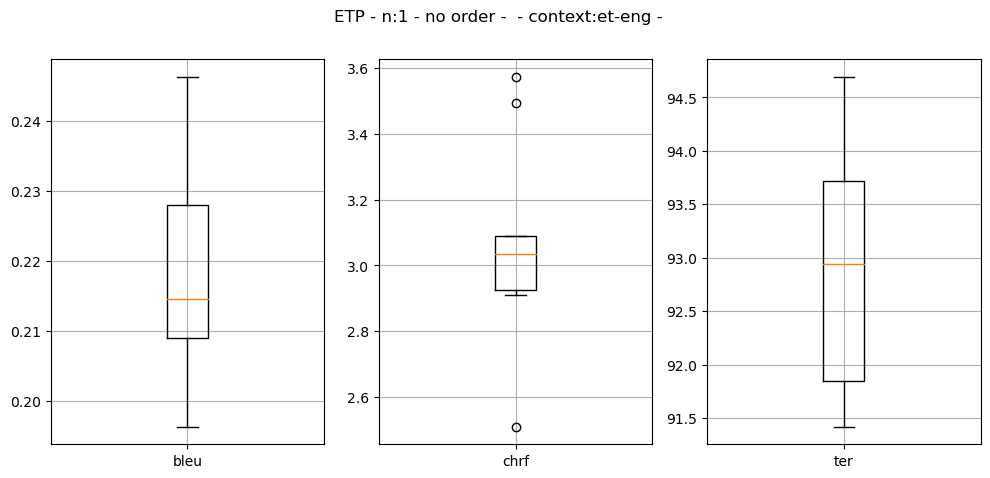

100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


Mean:
bleu      0.0
chrf      0.0
ter     100.0
dtype: float64
Standar deviation:
bleu    0.0
chrf    0.0
ter     0.0
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction:        
------------------------------------------------------------


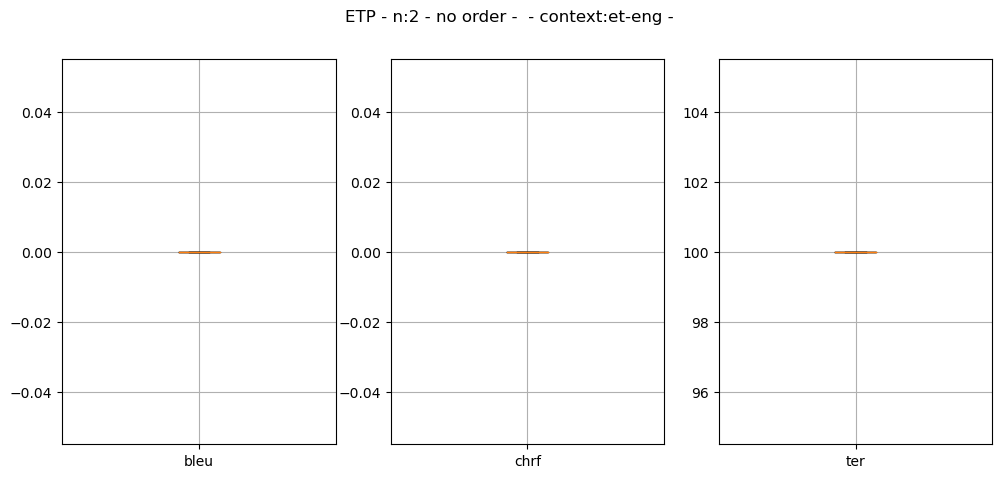

100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


Mean:
bleu      0.0
chrf      0.0
ter     100.0
dtype: float64
Standar deviation:
bleu    0.0
chrf    0.0
ter     0.0
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction:          
------------------------------------------------------------


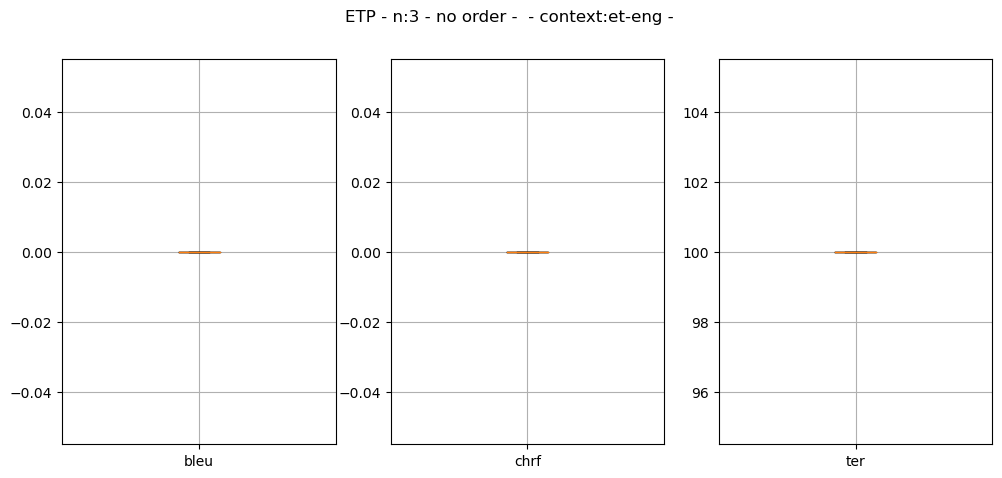

100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Mean:
bleu     0.447345
chrf     5.359546
ter     92.105303
dtype: float64
Standar deviation:
bleu    0.211707
chrf    0.856549
ter     1.117185
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: of the was of of of
------------------------------------------------------------


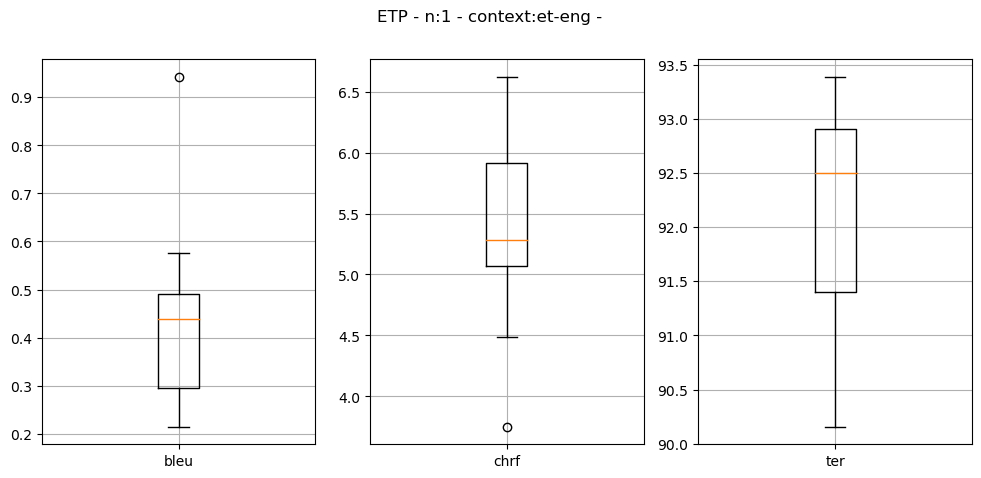

100%|██████████| 10/10 [00:01<00:00,  5.29it/s]


Mean:
bleu     0.000000
chrf     0.370272
ter     99.704938
dtype: float64
Standar deviation:
bleu    0.000000
chrf    0.166998
ter     0.345870
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction:        
------------------------------------------------------------


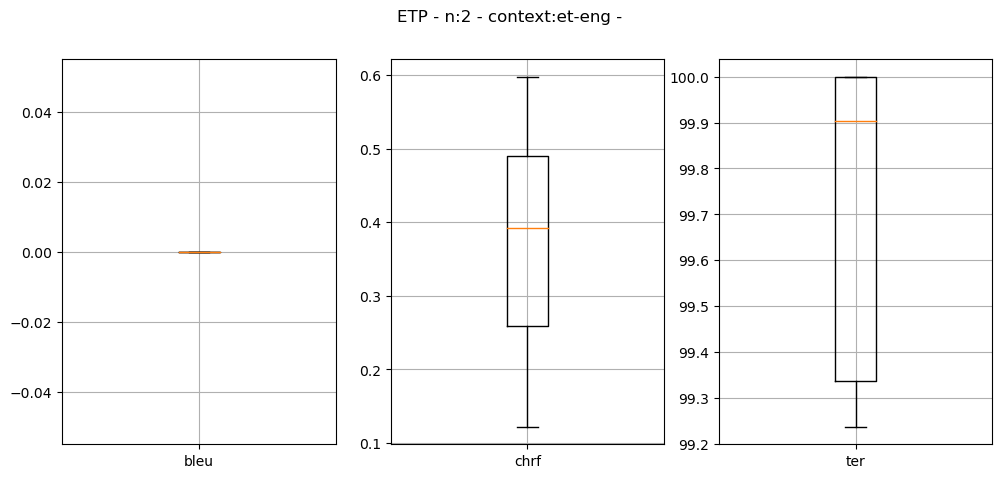

100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


Mean:
bleu     0.000000
chrf     0.356798
ter     99.690501
dtype: float64
Standar deviation:
bleu    0.000000
chrf    0.096966
ter     0.297104
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction:          
------------------------------------------------------------


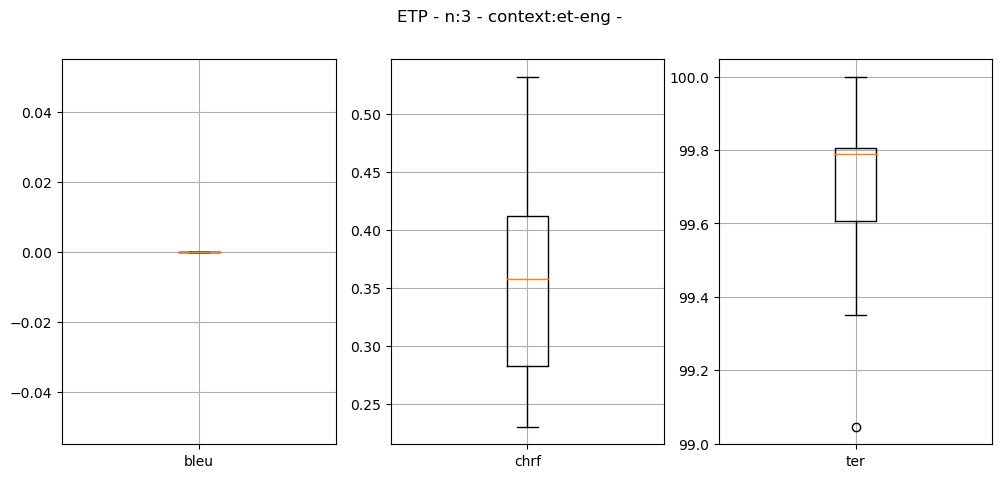

In [7]:
do_job(parameters, etp_etruscan, etp_english, "ETP")
# do_job(parameters, etp_etruscan, etp_english, "CIEP")

## Try with Naive Bayes

In [8]:
parameters = {
    "n": [2,3],
    "gamma": [0.1],
    "ignore_order": [False],
    "english_etruscan_context": [False, True],
    "use_bayes": [True]
}

100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Mean:
bleu      0.159994
chrf     12.609752
ter     101.482017
dtype: float64
Standar deviation:
bleu    0.023412
chrf    1.009155
ter     1.251688
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: cavatha cavatha citadel citadel saturnies saturnies paithinas
------------------------------------------------------------


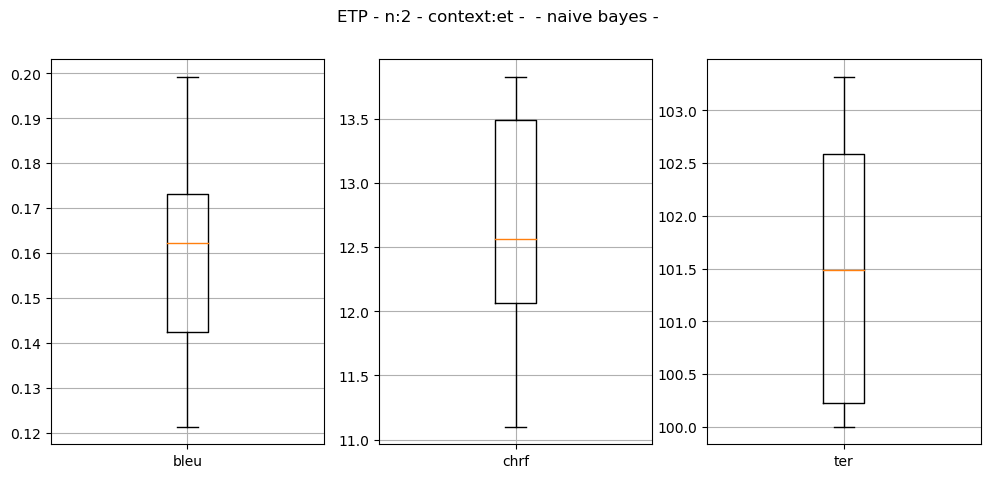

100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


Mean:
bleu      0.146435
chrf     12.708507
ter     103.866879
dtype: float64
Standar deviation:
bleu    0.030292
chrf    0.921586
ter     1.220142
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: of still cavis palpe palpe saturnies eight eight
------------------------------------------------------------


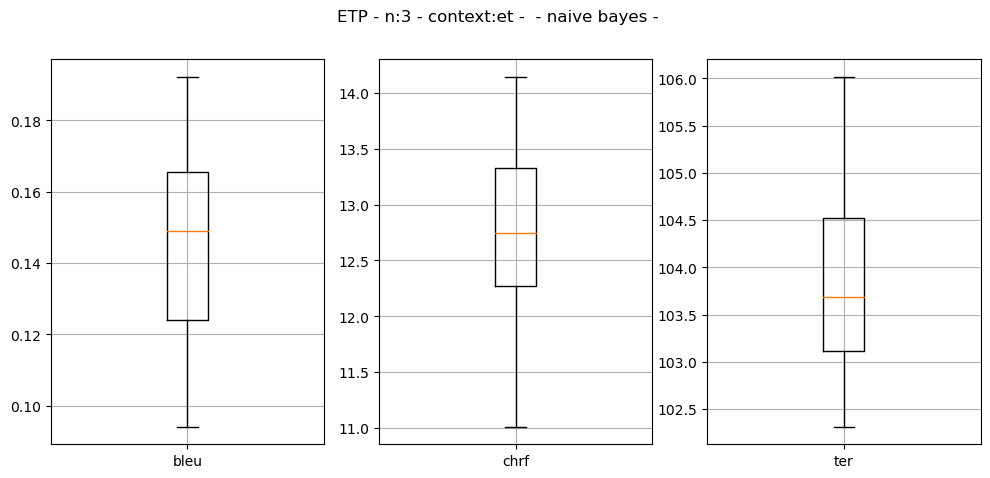

100%|██████████| 10/10 [00:30<00:00,  3.09s/it]


Mean:
bleu      0.055462
chrf      9.546564
ter     101.521621
dtype: float64
Standar deviation:
bleu    0.048865
chrf    1.820676
ter     0.850607
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction:   saturnies saturnies saturnies saturnies parx x
------------------------------------------------------------


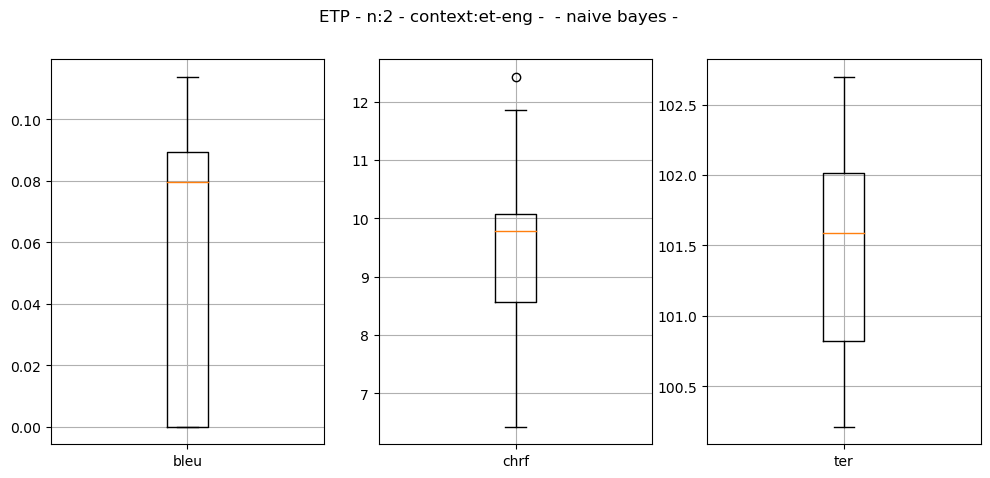

100%|██████████| 10/10 [00:45<00:00,  4.60s/it]


Mean:
bleu      0.055051
chrf      9.954692
ter     103.037845
dtype: float64
Standar deviation:
bleu    0.047891
chrf    2.103409
ter     1.005354
dtype: float64
------------------------------------------------------------
Etruscan: eca shuthic velus ezpus clensi cerine
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction:    saturnies cushu saturnies saturnies saturnies saturnies saturnies
------------------------------------------------------------


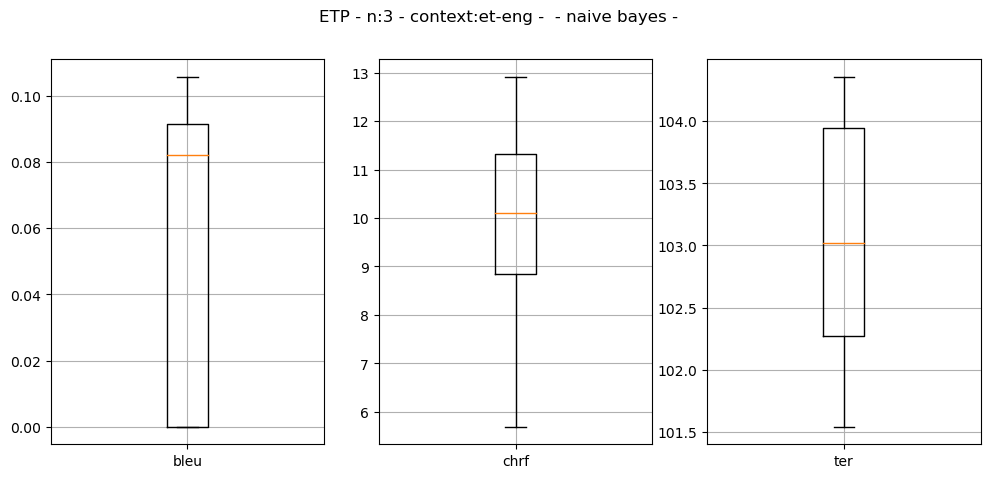

In [9]:
do_job(parameters, etp_etruscan, etp_english, "ETP")

# Testing

In [10]:
import importlib
import ngram_models
importlib.reload(ngram_models)
NGramModel = ngram_models.NGramModel

In [11]:
X = ["some text with some text", "other text", "something else"]
Y = ["del testo con del testo", "dell altro test", "qualcosaltro"]

In [12]:
settings = NGramModelSettings(
    n=2,
    gamma=10,
    ignore_order=False,
    english_etruscan_context=False,
    use_bayes=True
)

In [13]:
model = NGramModel(settings)
bt = BlankspaceTokenizer()
model.train(X, Y, bt, bt)

In [14]:
model.predict(X[0], bt)

('test test test test test test', -22.58559067075483)

In [15]:
model._predict_next(("some"), 4)

(('test', 'con', 'dell', 'altro'),
 (-4.334172991099025,
  -7.832049462763589,
  -7.832049462763589,
  -7.832049462763589))